#### Notebook options

In [120]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [122]:
### Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

#### Imports

In [123]:
# import bokeh
# import time
# import copy
# import scipy.stats as ss

# from coffea import hist, processor, nanoevents, util
# from coffea.nanoevents.methods import candidate
# from coffea.nanoevents import NanoAODSchema, BaseSchema

# import awkward as ak
# import numpy as np
# import glob as glob
# import itertools
# import pandas as pd
# from numpy.random import RandomState

# from dask.distributed import Client
# import inspect
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# from pltStyle import pltStyle
# import os
# # %matplotlib notebook 
# # %matplotlib notebook 

In [124]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mpl

In [125]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

In [126]:
tag = '_L5'                 ### L5 or L23, but L23 not supported since ages

### name of the specific run:
# add_tag = '_LHEflav1_TTBAR-Summer16-cFlip' #'_LHEflav1_TTBAR-JME' #'_LHEflav1_TTBAR-Summer16-cFlip' #'_Herwig-TTBAR' # '_TTBAR' #'_QCD' # '_testing_19UL18' # '' #fine_etaBins
# add_tag='_fine_etaBins'+add_tag
add_tag = '_LHEflav1_TTBAR-JME'

tag_full = tag+add_tag

In [127]:
def read_data(name, samp):
    df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

### Fitting the inverse median responses

In [128]:
df = pd.read_csv('out_txt/EtaBinsvsPtBins'+"Mean"+"_b"+tag_full+'.csv').set_index('etaBins')

In [129]:
etabins = np.append(df.index.to_numpy(), 5.191)
ptbins = np.append(df.columns.to_numpy(float), 10000)
ptbins_c = (ptbins[:-1]+ptbins[1:])/2

In [130]:
# samp = '_b'
# etabin = 1

# mean = read_data("Mean", samp)
# meanvar = read_data("MeanVar", samp)

In [131]:
# means = mean[:, etabin]
# means2fit = means[means!=0.0]
# ptbins2fit = ptbins[:-1][means!=0.0]
# meanvar2fit = np.abs(meanvar[means!=0.0,etabin])

# xvals = np.linspace(ptbins2fit.min() - (0.5), ptbins2fit.max()+(ptbins2fit[-1]-ptbins2fit[-11]),1000)

In [132]:
def ptscale2int(x, ptbins):
    ptmax = max(np.log10(ptbins))
    ptmin = min(np.log10(ptbins))
    z = np.log10(x)
    return ((z-ptmin)-(ptmax-z))/(ptmax-ptmin);

# def int2pt(z, ptbins):
#     Mi = np.min(np.log10(ptbins))
#     Ma = np.max(np.log10(ptbins))
#     pts = z/2*(Ma-Mi) + (Ma + Mi)/2
#     return 10**pts

In [133]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

def sum_cheb5_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4, c5 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) + 
           c5 * sp.special.eval_chebyt(5, xs) )
    return res

def sum_cheb3_tmp(x, ptbins, *p):
    c0, c1, c2, c3 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) )
    return res

def sum_cheb2_tmp(x, ptbins, *p):
    c0, c1, c2 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) )
    return res

In [134]:
def response_fnc(x, *p):
    p0, p1, p2, p3, p4, p5 = p
    return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))

def two_gaus_fnc(x, *p):
    p0, p1, p2, p3, p4, p5, p6, p7, p8 = p
    return (  p0
            + (p1/((np.log10(x)**2)+p2))
            + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))
            + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
           )
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [135]:
#### initial values borrowed from Winter14 data
#### https://github.com/cms-jet/JECDatabase/blob/master/textFiles/Winter14_V8_MC/Winter14_V8_MC_L5Flavor_AK5Calo.txt/
#### used for fit `response_fnc`
init_vals_2014 = {
    'b':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    'c' :
    [[ 0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041],
    [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749],
    [0.733505, 7.26794, 12.2028, -0.756302, 0.0895257, -1.96324],
    [0.932305, 1.15954, 17.1731, -0.471313, 2.58424, 0.254917]],
    'g' :
    [[0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485],
    [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263],
    [-0.972548, 38.8683, 2.47151, -44.0233, 0.0901665, -3.15495],
    [1.0655, -0.0680325, -0.509038, -8.59434e+06, 42.6162, 0.357177]],
    'd':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    'u':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    's':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],
    '':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    
}

Initial values for the two gaussian fit

In [136]:
#         fabscor->SetRange(3,2000);
init_two_gaus = [3,0,1,2,0,1,2,3,4]

#         fabscor->SetParameter(0,flog->GetParameter(3));
#         fabscor->SetParameter(1,flog->GetParameter(0));
#         fabscor->SetParameter(2,flog->GetParameter(1));
#         fabscor->SetParameter(3,flog->GetParameter(2));
#         fabscor->SetParLimits(1,0,5);
#         fabscor->SetParLimits(2,-20,20);
#         fabscor->SetParLimits(3,0,5);
#         fabscor->SetParameter(4,fgaus->GetParameter(0));
#         fabscor->SetParameter(5,fgaus->GetParameter(1));
#         fabscor->SetParameter(6,fgaus->GetParameter(2));
#         fabscor->SetParameter(7,fgaus->GetParameter(3));
#         fabscor->SetParameter(8,fgaus->GetParameter(4));
#         fabscor->SetParameter(9,fgaus->GetParameter(5));
#         fabscor->SetParLimits(6,0.1,100);
#         fabscor->SetParLimits(7,-100,0);
#         fabscor->SetParLimits(8,0,100);

Better starting fit values I found

In [137]:
init_vals_2014['b'][0] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]
init_vals_2014['b'][3] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]

In [138]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

In [139]:
mean = read_data("Median", samp)[:,etabin]
read_data("Mean", samp)[:,etabin]
mean

array([0.        , 0.        , 1.03338192, 1.04081589, 1.04243992,
       1.04154077, 1.04416202, 1.04250657, 1.03984692, 1.03377095,
       1.02799888, 1.02280418, 1.01788513, 1.01765495, 1.01295591,
       0.99156519, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

array([       nan,        nan, 1.03977582, 1.04602466, 1.04807861,
       1.04698256, 1.04962824, 1.04792919, 1.04560216, 1.03915295,
       1.03273185, 1.02623991, 1.02247307, 1.02278892, 1.01594523,
             -inf,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

In [140]:
# validpt_mask = np.isnan(mean)


### Fitting the mean responses

In [141]:
my_mapping = {"": "aJ",
              "_b": "bT",
              "_c": "cT",
              "_s": "sT",
              "_g": "gT",
              "_ud": "qT",
              "_u": "qT",
              "_d": "qT"}

In [142]:
np.sqrt(meanvar2fit)/means2fit
min_rel_uncert = 0.001

meanstd = np.sqrt(meanvar2fit)
where_limit_std = meanstd>min_rel_uncert
meanstd[where_limit_std] = min_rel_uncert*means2fit[where_limit_std]

array([0.00096119, 0.00080553, 0.0009232 , 0.00071407, 0.00073371,
       0.00077058, 0.00055308, 0.00060184, 0.00073567, 0.00084863,
       0.00134151, 0.00173756, 0.00301807])

Fitting subsample:   Eta bin = :  0
Winter 14 fit failed
Two fits failed


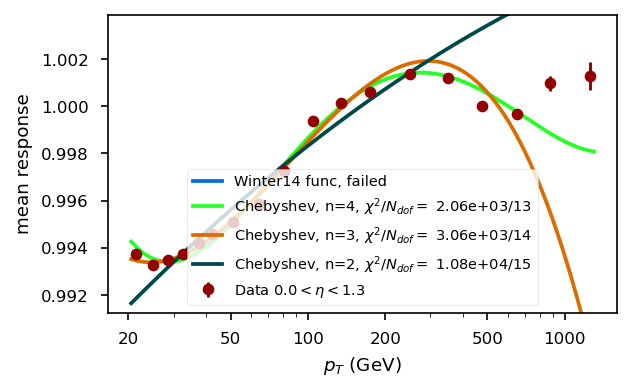

Fitting subsample:   Eta bin = :  1
Winter 14 fit failed
Two fits failed


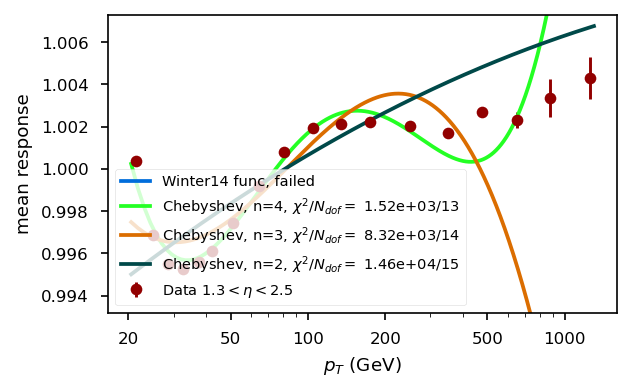

Fitting subsample:   Eta bin = :  2
Two fits failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


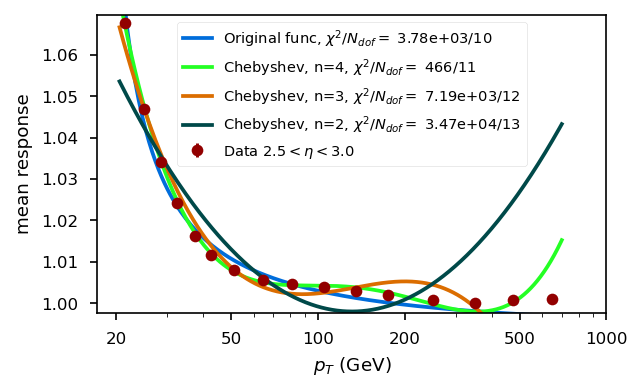

Fitting subsample:   Eta bin = :  3
Winter 14 fit failed
Two fits failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


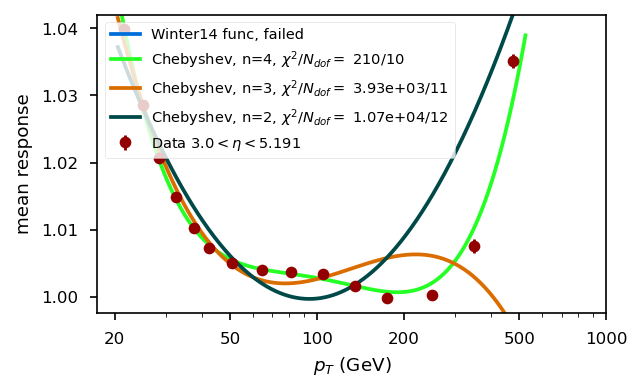

Fitting subsample:  _b Eta bin = :  0
Two fits failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


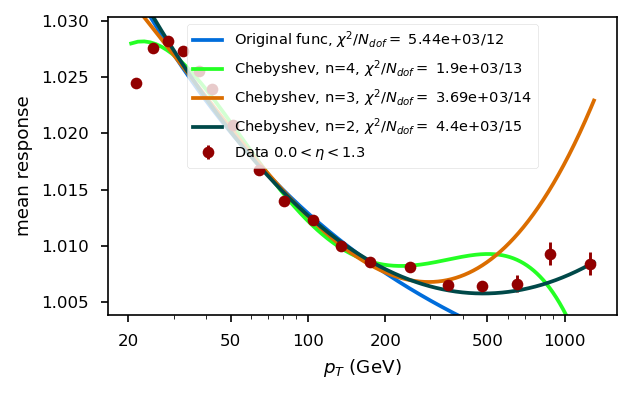

Fitting subsample:  _b Eta bin = :  1
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:10: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


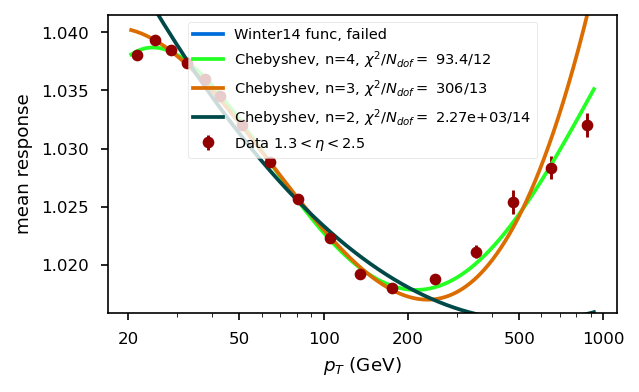

Fitting subsample:  _b Eta bin = :  2
Winter 14 fit failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


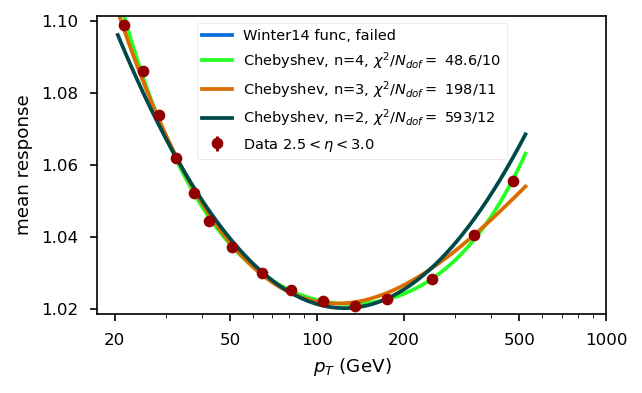

Fitting subsample:  _b Eta bin = :  3
Two fits failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_28470/1491362534.py:10: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


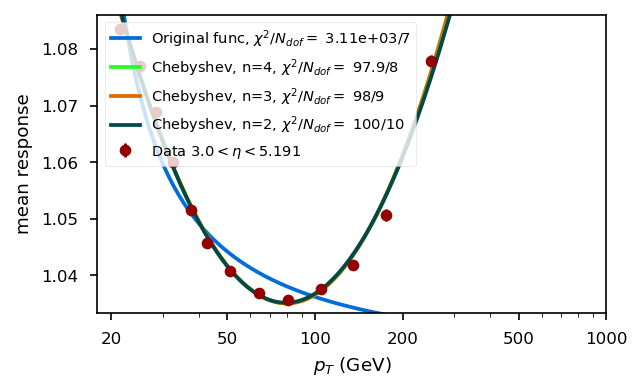

Fitting subsample:  _c Eta bin = :  0
Winter 14 fit failed
Two fits failed


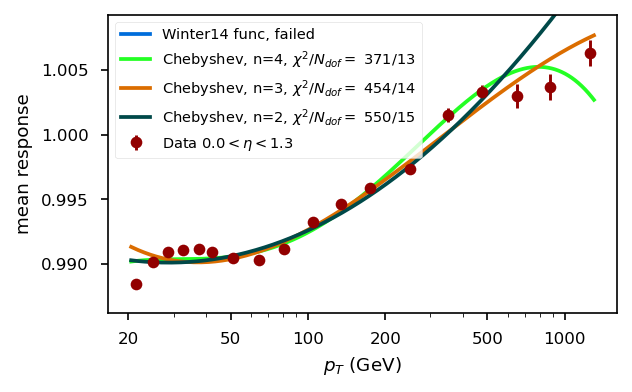

Fitting subsample:  _c Eta bin = :  1
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:10: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


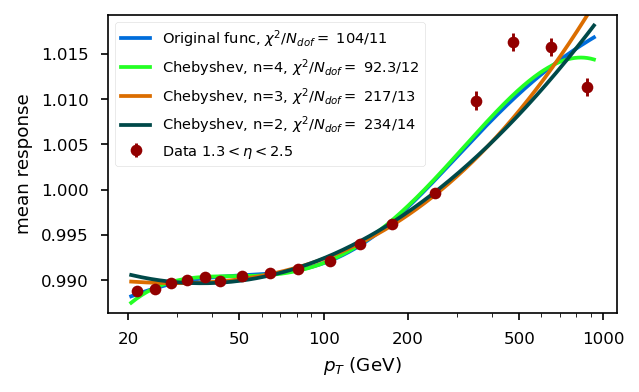

Fitting subsample:  _c Eta bin = :  2
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


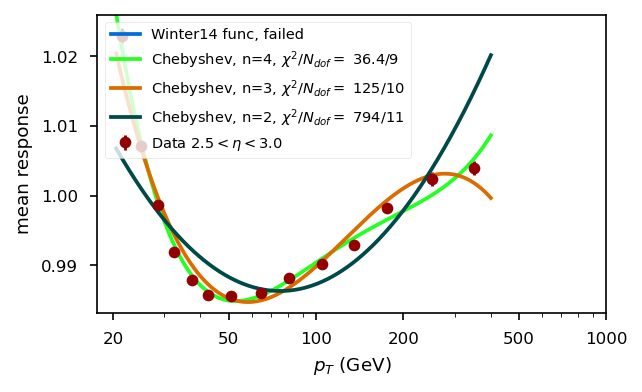

Fitting subsample:  _c Eta bin = :  3
Two fits failed


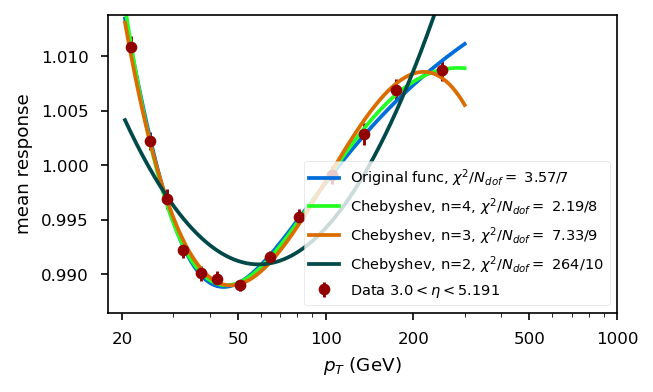

Fitting subsample:  _u Eta bin = :  0
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


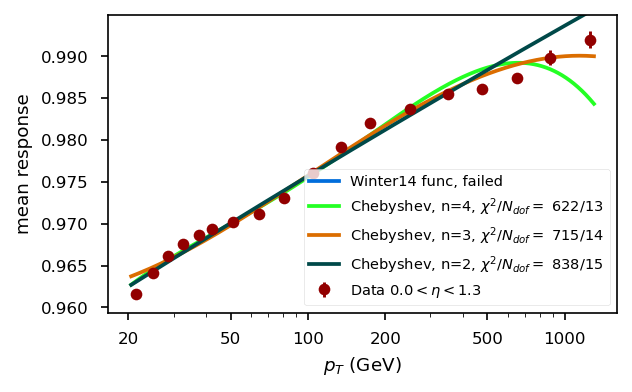

Fitting subsample:  _u Eta bin = :  1
Winter 14 fit failed
Two fits failed


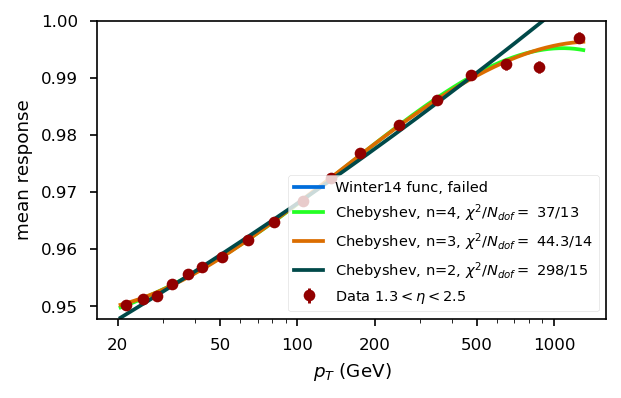

Fitting subsample:  _u Eta bin = :  2
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


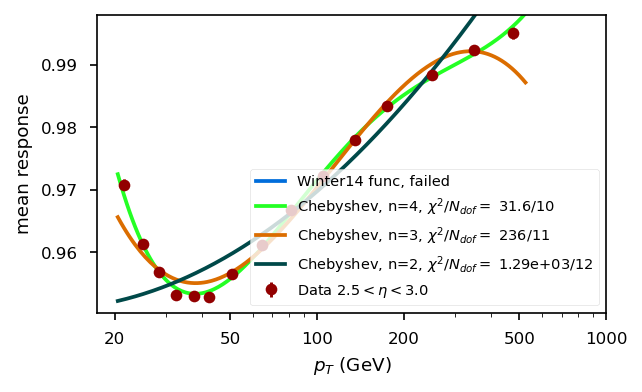

Fitting subsample:  _u Eta bin = :  3
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


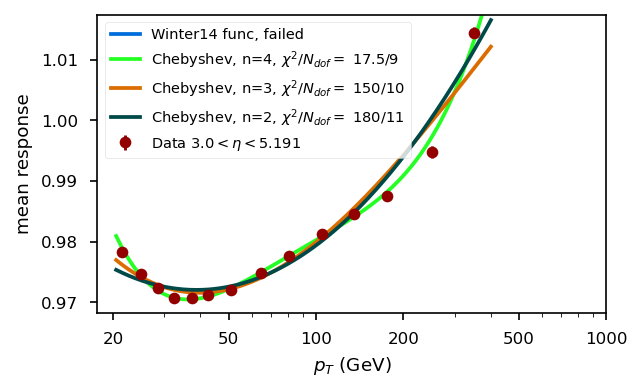

Fitting subsample:  _d Eta bin = :  0
Winter 14 fit failed
Two fits failed


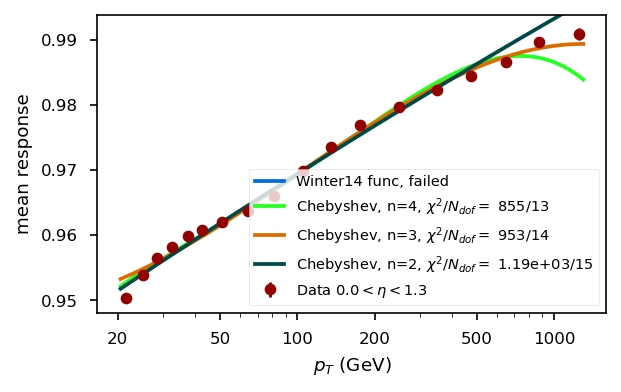

Fitting subsample:  _d Eta bin = :  1
Winter 14 fit failed
Two fits failed


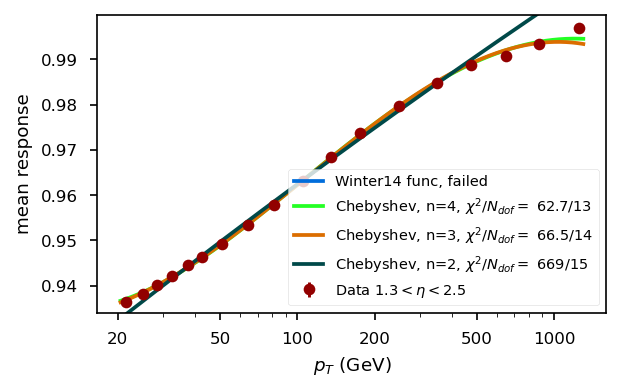

Fitting subsample:  _d Eta bin = :  2
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


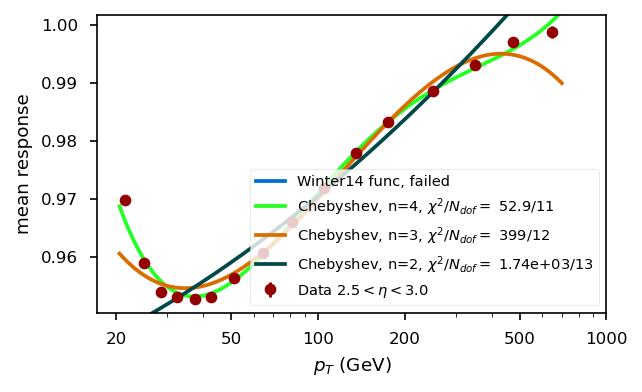

Fitting subsample:  _d Eta bin = :  3
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


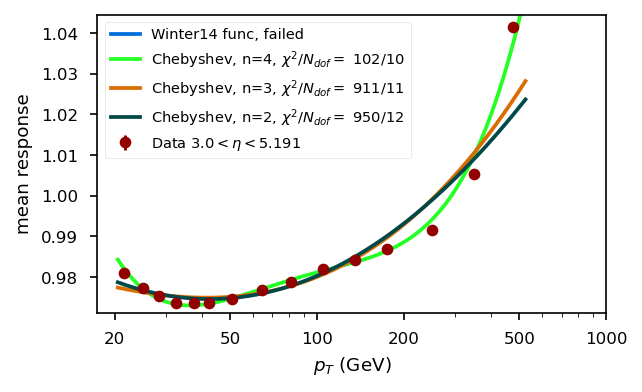

Fitting subsample:  _g Eta bin = :  0
Winter 14 fit failed
Two fits failed


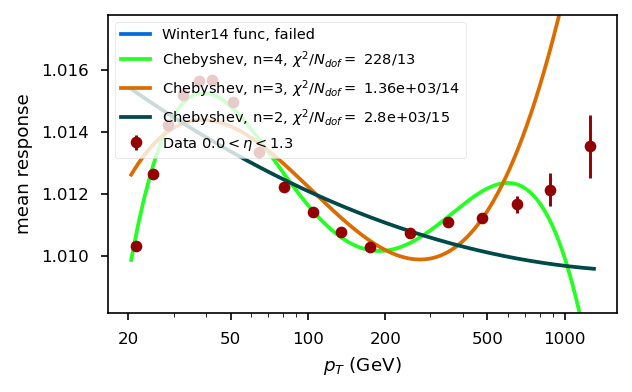

Fitting subsample:  _g Eta bin = :  1
Winter 14 fit failed
Two fits failed


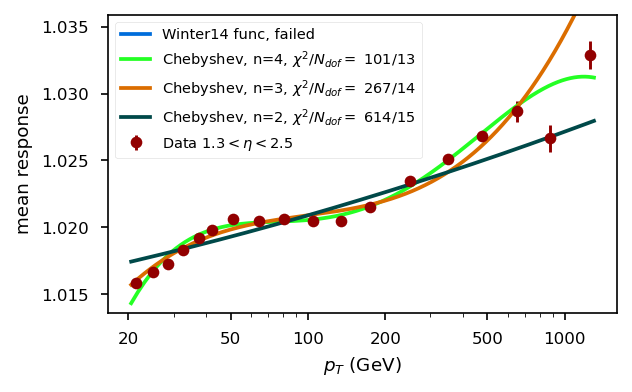

Fitting subsample:  _g Eta bin = :  2
Winter 14 fit failed
Two fits failed


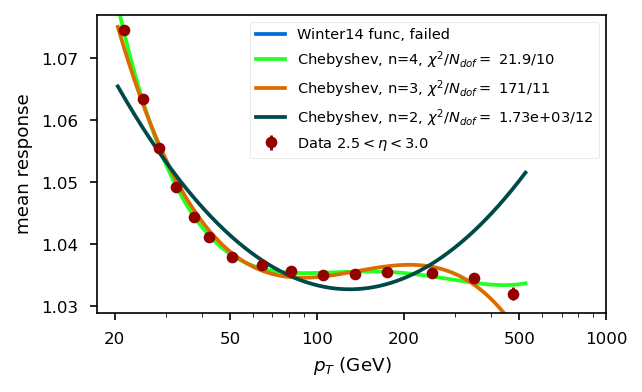

Fitting subsample:  _g Eta bin = :  3
Winter 14 fit failed
Two fits failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


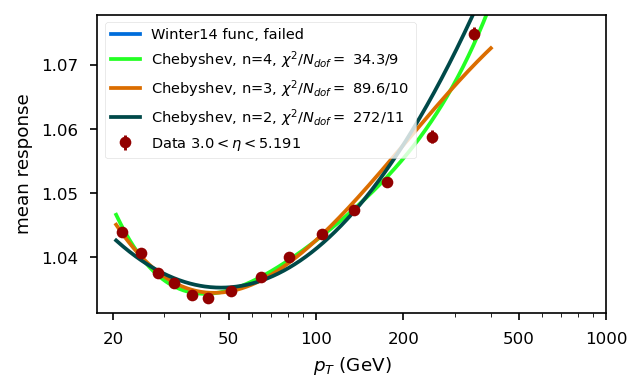

Fitting subsample:  _s Eta bin = :  0
Winter 14 fit failed
Two fits failed


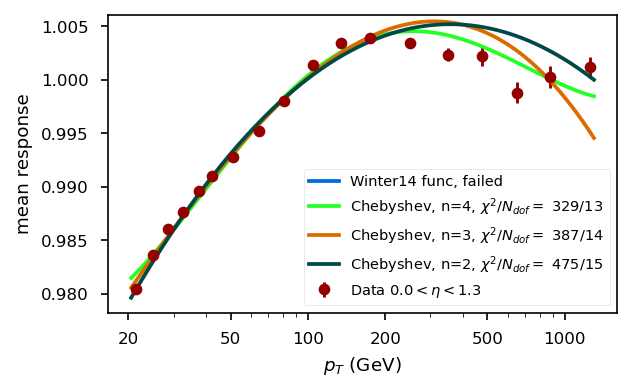

Fitting subsample:  _s Eta bin = :  1
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:10: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


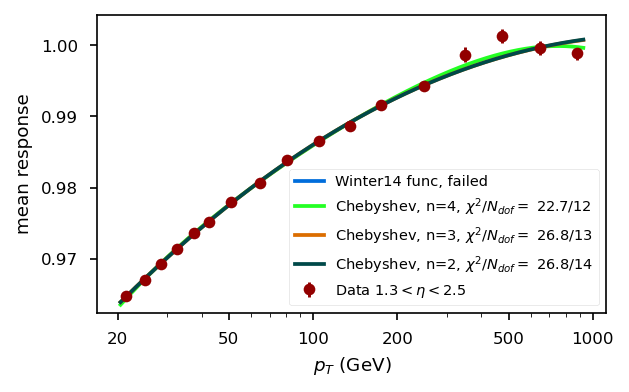

Fitting subsample:  _s Eta bin = :  2
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_28470/1491362534.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


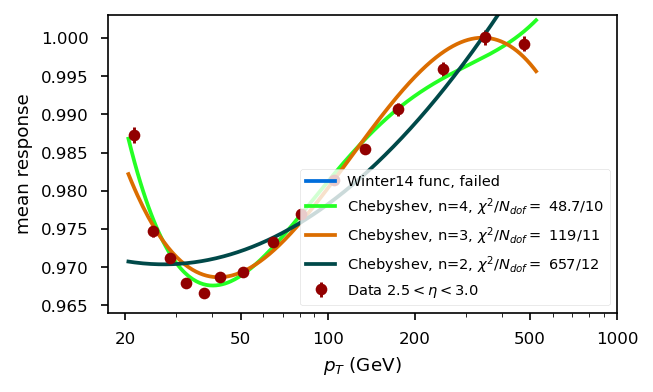

Fitting subsample:  _s Eta bin = :  3
Winter 14 fit failed
Two fits failed


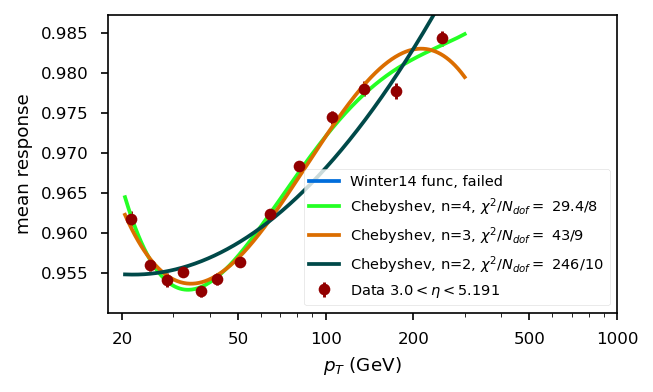

In [145]:
import sympy 
from sympy import chebyshevt
  
x = sympy.symbols('x')

subsamples = ['','_b', '_c', '_u', '_d', '_g', '_s']
# subsamples = ['_b', '_c']
### Put the minimum limit on the relative uncertainty to min_rel_uncert
min_rel_uncert = 0.001

fit_res_all ={}
# etabins_all ={}
# nofpars_all ={}
for samp in subsamples:
    fit_res = []
    etabins_samp = []
    nofpars = []
    for etabin in range(4):
        print('Fitting subsample: ', samp, 'Eta bin = : ', etabin)
        mean = 1/read_data("Median", samp)[:,etabin]
        meanvar = mean**2*read_data("MedianStd", samp)[:,etabin]**2

        start = np.searchsorted(ptbins_c, 20, side='left')
        mean_range = range(start-1, len(mean)-8)
        

#         mean_range = mean_range_pt[:-1]

#         ptbins2fit = ptbins[mean_range_pt]
#         ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
        means = mean[mean_range]
        ptbins2fit = ptbins_c[mean_range]
        validpt_mask = ~(np.isnan(means) | np.isinf(means) | (means==0))
        
        means2fit = means[validpt_mask]
        ptbins2fit = ptbins2fit[validpt_mask]
        meanvar2fit = np.abs(meanvar[mean_range][validpt_mask])
        
        ### Put the minimum limit on the relative uncertainty to min_rel_uncert
        meanstd = np.sqrt(meanvar2fit)
        where_limit_std = meanstd>min_rel_uncert
        meanstd[where_limit_std] = min_rel_uncert*means2fit[where_limit_std]
        
        fit_min_lim = min(ptbins[:-1][mean_range][validpt_mask])
        fit_max_lim = max(ptbins[1:][mean_range][validpt_mask])

        xvals = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+50,1000) #-200 to plot the fitted curved outside of the points
        def sum_cheb(x, *p):
            return sum_cheb_tmp(x, ptbins2fit, *p)
        def sum_cheb5(x, *p):
            return sum_cheb5_tmp(x, ptbins2fit, *p)    
        def sum_cheb3(x, *p):
            return sum_cheb3_tmp(x, ptbins2fit, *p)  
        def sum_cheb2(x, *p):
            return sum_cheb2_tmp(x, ptbins2fit, *p)  
            
        try:
            p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_2014[samp[-1:]][etabin]) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
            p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=meanstd)
        except(RuntimeError):
            print("Winter 14 fit failed")
            p_resp, p_resp_err = [[np.nan]*6]*2
        #      = np.nan*6

        try:
            p_resp2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=init_two_gaus) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
            p_resp_err2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=p_resp2, sigma=meanstd)
        except(RuntimeError):
            print("Two fits failed")
            p_resp2, p_resp_err2 = [[np.nan]*9]*2
        #      = np.nan*6

        
        # p_resp_err
        p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
        p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=meanstd)
        p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
        p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=meanstd)
        p_cheb3_1, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
        p_cheb3, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=p_cheb3_1, sigma=meanstd)
        p_cheb2_1, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=[ 1, 1, 1])
        p_cheb2, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=p_cheb2_1, sigma=meanstd)
        
        expr = 0
        for ii in range(len(p_cheb3)):
            expr+=p_cheb3[ii]* chebyshevt(ii,x)
        poly_coefs = np.array(sympy.Poly(expr).all_coeffs(), dtype=float)
#         len(poly_coefs)
        
        fit_res = np.concatenate([fit_res,
                                  [etabins[etabin], etabins[etabin+1],
                                   len(p_cheb3), 
                                   fit_min_lim, fit_max_lim],
                                  p_cheb3 ])
        nofpars.append(len(p_cheb3))
        
        yvals_resp = response_fnc(xvals, *p_resp)
        yvals_resp_err = response_fnc(xvals, *p_resp_err)
        yvals = sum_cheb(xvals, *p_cheb)
#         yvals1 = sum_cheb(xvals, *p_cheb1)
        yvalsC5 = sum_cheb5(xvals, *p_cheb5)
#         yvalsC5_1 = sum_cheb5(xvals, *p_cheb5_1)
        yvalsC3 = sum_cheb3(xvals, *p_cheb3)
        yvalsC2 = sum_cheb2(xvals, *p_cheb2)

        chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanstd**2)
        chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanstd**2)
        chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/meanstd**2)
        chi2_C3 = np.sum((sum_cheb3(ptbins2fit, *p_cheb3) - means2fit)**2/meanstd**2)
        chi2_C2 = np.sum((sum_cheb2(ptbins2fit, *p_cheb2) - means2fit)**2/meanstd**2)
        Ndof_C4 = len(ptbins2fit) - 5
        Ndof_C5 = len(ptbins2fit) - 6
        Ndof_C3 = len(ptbins2fit) - 4
        Ndof_C2 = len(ptbins2fit) - 3
        Ndof_resp = len(ptbins2fit) - 6


        fig, ax = plt.subplots()

        plt.errorbar(ptbins2fit, means2fit, yerr=meanstd, marker='o',
                     linestyle="none", label=f'Data {etabins[etabin]}'+r'$<\eta<'+f'${etabins[etabin+1]}')

        eta_string = '_eta'+str(etabins[etabin])+'to'+str(etabins[etabin+1])
        eta_string = eta_string.replace('.','')
        if np.isnan(chi2_resp): 
            winter14_lab = 'Winter14 func, failed'
        else:
            winter14_lab= 'Original func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)

        ax.plot(xvals, yvals_resp_err, label=winter14_lab, linewidth=1.8);
        ax.plot(xvals, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.8);
#         ax.plot(xvals, yvalsC5, label=r'Chebyshev, n=5, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C5, Ndof_C5),linewidth=1.8);
        ax.plot(xvals, yvalsC3, label=r'Chebyshev, n=3, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C3, Ndof_C3),linewidth=1.8);
        ax.plot(xvals, yvalsC2, label=r'Chebyshev, n=2, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C2, Ndof_C2),linewidth=1.8);

    
#         yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
#         y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
    #     print("ynorm = ", y_norm)
    #     print("yerr = ", yerr_norm)
        std = meanstd
        norm_pos = (std<0.1) &  (std != np.inf)
    #     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
        ax.set_ylim(np.min((means2fit-std)[norm_pos])-0.002 ,np.max((std+means2fit)[norm_pos])+0.002)

        ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        
        ax.set_xticks([])
        ax.set_xticks([20, 50, 100, 200, 500, 1000])
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

        # ax.set_ylim([0.8,1.1])
        ax.legend(prop={'size': 7})
#         if not test_run:
#             plt.savefig('fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.savefig('fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#         else:
#         plt.savefig('test/fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#         plt.savefig('test/fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        # fig.set_size_inches(6, 4, forward=True)
        plt.show();
        plt.close();
        
    num = int(5 + fit_res[2])
    fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
#     etabins_samp = np.reshape(etabins_samp,((len(etabins_samp)//2), 2))
    fit_res_all[my_mapping[samp]] = fit_res
#     etabins_all[my_mapping[samp]] = etabins_samp
#     nofpars_all[my_mapping[samp]] = nofpars
'a';

In [ ]:
header_txt = ('# L5 flavor corrections for IC5 algorithm \n'+
'# [gJ] (gluons from diJet mixture) \n'+
'# [qJ] (uds quarks from diJet mixture) \n'+
'# [cJ] (c quark from diJet mixture) \n'+
'# [bJ] (b quark from diJet mixture) \n'+
'# [gT] (gluons from ttbar events) \n'+
'# [qT] (uds quarks from ttbar events) \n'+
'# [cT] (c quark from ttbar events) \n'+
'# [bT] (b quark from ttbar events) \n'+
'# energy mapping: ptGen = (pt - p5)/p6 \n'+
'# parametrization: p2+p3*logPt+p4*logPt^2, constant if Pt<p0 or Pt>p1 \n'+
'#etamin  etamax  #ofparameters  ptmin  ptmax    p2         p3        p4     mapping: p5        p6 ')

In [ ]:
# with open("Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4chs.txt", 'w') as file:
#     file.write(header_txt+'\n')
#     for key in fit_res_all.keys():
#         file.write('['+key+']\n')
#         afile.write('{1 JetEta 1 JetPt ([0] + [1]*log10(x) + [2]*log10(x)*log10(x) + [3]*log10(x)*log10(x)*log10(x)) Correction L5Flavor}\n')
#         for row in fit_res_all[key]:
#             file.write('\t'.join([str(item) for item in row[:2]])+'\t'+str(int(row[2]))+'\t'+'\t'.join([str(item) for item in row[3:]])+'\n');

# 4; ## to suppress printouts of write

### Fit a specific $\eta$ $p_T$ bin

In [ ]:

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
chi2s = np.zeros((jetpt_length, jeteta_length))
meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []

N_converge = 0
N_not_converge = 0

FitFigDir = 'fig/response_pt_eta'+samp+tag_full
print("Images will be saved under ", FitFigDir)
if not os.path.exists(FitFigDir):
    os.mkdir(FitFigDir)
    
edd = output['ptresponse'+samp].axis('ptresponse').edges()
plot_pt_edges = edd[0:np.nonzero(edd>=2.0)[0][0]]
# plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
f_xvals = np.linspace(0,5,5001)
response_edges = output['ptresponse'+samp].axis('ptresponse').edges()[1:]

In [ ]:
# np.where(xvals>=p[1]+np.abs(p[2])*1.5)

In [ ]:
samp=''

In [ ]:
etabins

In [ ]:
samp='_g'

In [ ]:
ptbins

In [ ]:
# histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(4.538,  4.716)).integrate('pt', hist.Interval(15, 40))
# histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-4.716, -4.538)).integrate('pt', hist.Interval(15, 40))

histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(0,  1.3)).integrate('pt', hist.Interval(23, 27))
histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-1.3, 0)).integrate('pt', hist.Interval(23, 27))
histo = (histoMi+histoPl)
yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

N = histo.integrate('ptresponse').values()[('QCD',)]-histo.values()[('QCD',)][0]

####################### Calculate median and rms ############################
yvals_cumsum = np.cumsum(yvals)
med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>0 else 0
median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
                                                                          - response_edges[med_bin])

hist_mean = np.sum(xvals*yvals)/sum(yvals) 
hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
medianstd = 1.253 * hist_rms/np.sqrt(N)

####################### Fitting ############################
nonzero_bins = np.sum(yvals>0)
if nonzero_bins<2 or N<50:
    p2=[0,0,0]
    chi2 = np.nan
    arr = np.array([[np.nan]*3]*3)
    Ndof = 0
#                 print("Too little data points, skipping p = ", p2)
else:
    try:
        p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
        N_converge += 1
             ######## Second Gaussian ########
        xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
        xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
        xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
#                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)

        if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
            xfit_l = xfit_l-1
            xfit_h = xfit_h+1
            if len(range(xfit_l,xfit_h))<6:
                xfit_l = xfit_l-1
                xfit_h = xfit_h+1
        if xfit_l<0:
            xfit_h-=xfit_l
            xfit_l = 0
        xvals2 = xvals[xfit_l: xfit_h]
        yvals2 = yvals[xfit_l: xfit_h]
#                     if ptBin.lo>290:
#                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
#                         print("yvals = ", yvals)
#                         print("yvals2 = ", yvals2)
        p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

        ygaus = gauss(xvals, *p2)
        chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
        Ndof = len(xvals2)-3
#                     if chi2<50000:
#                         pass
#                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#                     else:
#                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
    except(RuntimeError):
        p2=[0,0,0]
#                     print("Fit failed because of non-convergance, p = ", p2)
        chi2 = np.nan
        arr = np.array([[np.nan]*3]*3)
        Ndof = 0
        N_not_converge += 1

fgaus2 = gauss(f_xvals, *p2)
histo = histo.rebin('ptresponse', plot_response_axis)
width_ik = np.abs(p2[2])




In [ ]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

In [ ]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

In [ ]:
print('-----'*10)
print("All done. Congrats!")